# Klassifizierung mithilfe des Kolmogorov-Smirnov Tests
Author: Jan Lorenzen <br>
Date: 16.01.2022

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import random as rand
from scipy.stats import kstest, ks_2samp
from os import listdir
from os.path import isfile, join
from IPython.display import clear_output

In [2]:
class ksClassifier:
    """
    Class that uses the Kolmogorov Smirnov Test to classify different kinds of metal
    """
    
    def __init__(self, main_path: str, create_sample: bool = False, set_sample: bool = False, sample_list = [], 
                 compare_with_samples: bool = False, samples_mean_path: str = '', shuffle: bool = False, 
                 local_shuffle: bool = False, buckets: int = 2, multi_shuffle: bool = False, num_of_predictions: int = 20,
                 area_shuffle: bool = False, area: tuple = ()):
        """
        Initialize the all the variables, the DataFrame with the known materials (from main_path), create the sample arrays
        if compare_with_samples == True and load in the sample Data, if no fixed sample array is given.
        
        Args:
            main_path(str) -> the location of the materials.csv
            create_sample(bool) -> set true if you want to create a fixed sample
            set_sample(bool) -> set true to set a fixed sample
            sample_list(List) -> list of your fixed sample
            compare_with_samples(bool) -> set true if you want to compare with sample arrays
            samples_mean_path(str) -> path to the sample arrays
            shuffle(bool) -> set true if you want your arrays to be shuffled before prediction
            local_shuffle(bool) -> set true if you want the array to be shuffled in even parts
            buckets(int) -> number of even parts for the local_shuffle
            multi_shuffle(bool) -> set true if you want to make multiple predictions with different shuffles for one material
            num_of_predictions(int) -> how many predictions the 'multi_shuffle' should do
            area_shuffle(bool) -> set true if you want to shuffle only one area
            area(tuple) -> indices (start, end) for the area_shuffle
        """
        self.compare_with_samples = compare_with_samples
        self.shuffle = shuffle
        self.local_shuffle = local_shuffle
        self.multi_shuffle = multi_shuffle
        self.area_shuffle = area_shuffle
        self.create_sample = create_sample
        self.set_sample = set_sample
        
        self.samples = sample_list
        self.num_of_predictions = num_of_predictions
        self.buckets = buckets
        self.area = area
        
        self.materials = pd.read_csv(main_path, skipinitialspace=True, header=1)
        
        #Load comparison samples
        if compare_with_samples:
            self.sample_materials = self.load_samples(samples_mean_path)
            self.samples_1sek = self.sample_materials[0]
            self.samples_1min = self.sample_materials[1]
            self.samples_5min = self.sample_materials[2]
            self.samples_15min = self.sample_materials[3]
            self.samples_1std = self.sample_materials[4]
            self.sample_arr = [self.materials, self.samples_1sek, self.samples_1min, self.samples_5min, self.samples_15min, self.samples_1std]
        
        #Variables to calculate progress as percent when running the class
        self.test_size = 0
        self.current = 0
        self.percent = 0
        
        self.acc = 0
        
        #read in sample files
        if not self.set_sample:
            self.samples = self.read_sample_files(sample_path)
        
        
    def predict(self, inputs: list) -> list:
        """
        Predicts what type of metal the input is / are, with help of the kstest
        
        Args:
            inputs(list) -> list of Pandas Series
            
        Returns:
            list -> list with the predicted labels
        """
        
        predictions = []
        predicted = None
        
        #materials converted to cumulative distributions will be saved in this variable
        cdf_inputs = inputs.copy()
        
        for col in cdf_inputs:
            #if compare_with_samples is true, then load the sample array as the known material
            #if compare_with_samples is false, then load the materials.csv as known material
            if self.compare_with_samples:
                predicted = self.ks_test(self.sample_arr, col)
            else:
                predicted = self.ks_test(self.materials, col)
            predictions.append(predicted)
        
        return predictions
    
    
    def test(self, sample_path: str, test_size: int = 100):
        """
        Used to test this class with sample inputs
        
        Args:
            sample_path(str) -> path where the sample files are located
            test_size(int) -> size of the batch of sample datapoints
            
        Returns:
            list -> list which contains three lists
                1. test labels
                2. predicted labels
                3. times of the simulated data
        """
        
        self.test_size = test_size
        self.current = 0
        self.perc = 0
        
        if self.create_sample:
            return self.create_test_data(self.samples, size=test_size)
        elif self.set_sample:
            X_test, y_test, times = self.samples
        else:
            X_test, y_test, times = self.create_test_data(self.samples, size=test_size)
        
        labels_pred = self.predict(inputs=X_test)
        
        return list((y_test, labels_pred, times))
    
    
    def read_sample_files(self, path: str, alt_samples = False) -> list:
        """
        Read in test files, to test this class and the algorithm
        
        Args:
            path(str) -> The path of the folder, where all the sample files are located
            
        Returns:
            list -> A 2d list that contrains Tuples with the form [0] = a DataFrame and [1] a label for the DataFrame
                    example: [(Pandas DataFrame, 'Al_1'), (Pandas DataFrame, 'Cu_4'), ...]
        """
        
        # read filenames from folder 
        files = [f for f in listdir(path) if isfile(join(path, f))]
        labels, times = self.filenames_to_labels(files)
               
        # mac thing, if its in filename, delete
        if '.DS_Store' in files:
            files.remove('.DS_Store')
        
        # read in all sample files as Pandas DataFrames, ignore the first 140 rows and the first 2 columns
        if alt_samples:
            sample_data = [pd.read_csv(path + "/" + elem, skipinitialspace=True).iloc[:, :].reset_index(drop=True) for elem in files]
            return sample_data, labels, times
        else:
            sample_data = [pd.read_csv(path + "/" + elem, skipinitialspace=True).iloc[140:, 2:].reset_index(drop=True) for elem in files]
            
        # zip all data and labels together and return as list
        return list(zip(sample_data, labels, times))
    
    
    def filenames_to_labels(self, filenames: list) -> list:
        """
        Converts the filenames of the sample files to more useful labels.
        Sample files are in the form for example '15_min_Al_1.csv' that will convert to 'Al_1'
        
        Args:
            filenames(list) -> A list of filenames
            
        Returns:
            list -> list of labels
            list -> list of sample times
        """
        
        metal_labels = ['Al_1', 'Al_2', 'Al_3', 'Al_4', 'Al_5', 'Asilikos',
                        'Batterien', 'Cu_0', 'Cu_1', 'Cu_2', 'Cu_3', 'Cu_4', 
                        'Cu_5', 'E-Schrott', 'Erdreich_1', 'Erdreich_2', 
                        'Erz', 'Melamine', 'PVC', 'Stuckgips', 'Zement']
        
        label_list = []
        time_labels = []
        
        for file in filenames:
            for label in metal_labels:
                if label in file:
                    time = file.split('_')[0]
                    label_list.append(label)
                    time_labels.append(time)
                    
                    
        return label_list, time_labels
    
    
    def convert_to_cumulative(self, df: pd.DataFrame, columns: list = []) -> pd.DataFrame:
        """
        Converts a DataFrame to its cumulative distribution
        
        Args:
            df(pd.DataFrame) -> Pandas DataFrame that will be converted
            columns(list) -> A list of columnnames
        
        Returns:
            pd.DataFrame -> A new DataFrame which contains the cumulative Data
        """
        
        cumulative_data = df.copy()

        # devide each cell entry by the some of its column
        if len(columns) != 0:
            for column in columns:
                cumulative_data[column] = cumulative_data[column] / cumulative_data[column].sum()
            cumulative_data = cumulative_data.iloc[:, 1:].cumsum()
        else:
            cumulative_data = cumulative_data / cumulative_data.sum()
            cumulative_data = cumulative_data.cumsum()
        
        return cumulative_data
    
    
    def load_samples(self, path: str):
        """
        Load comparison samples and devide them into corresponding lists according to their sample time 
        
        Args:
            path(str) -> Path of the sample files
        
        Returns:
            tuple -> A tuple containing sample arrays of 1sek, 1min, 5min, 15min and 1std
        """
        
        data, labels, time = self.read_sample_files(path, alt_samples = True)
        
        data_1sek = pd.DataFrame()
        data_1min = pd.DataFrame()
        data_5min = pd.DataFrame()
        data_15min = pd.DataFrame()
        data_1std = pd.DataFrame()
        
        for i in range(len(data)):
            if time[i] == '1sek':
                data_1sek[labels[i]] = data[i]
            if time[i] == '1min':
                data_1min[labels[i]] = data[i]
            if time[i] == '5min':
                data_5min[labels[i]] = data[i]
            if time[i] == '15min':
                data_15min[labels[i]] = data[i]
            if time[i] == '1std':
                data_1std[labels[i]] = data[i]
         
        return data_1sek, data_1min, data_5min, data_15min, data_1std
        
    def create_test_data(self, samples: list, size: int = 100) -> tuple:
        """
        Creates test data, one list with metal data and one list with its corresponding labels
        
        Args:
            samples -> list with Tupels in form of (Pandas DataFrame, label)
            size -> size of the test list
            
        Returns:
            Tupel -> Tupel with the sample list at index 0, label list at index 1 and sample times at index 2
        """
        
        sample_list = []
        label_list = []
        time_list = []
        
        for i in range(size):
            random_sample = rand.choice(samples) #pick a random entry from the samples list
            random_col_index = str(rand.randint(0,99)) #random column index
            
            sample_list.append(random_sample[0].loc[:, random_col_index]) #add the random sample (as Pandas Series) to the sample list
            label_list.append(random_sample[1]) #add corresponding label to the label list
            time_list.append(random_sample[2]) #add sample times to the time list
        
        return sample_list, label_list, time_list
    
    
    def ks_test(self, known_material, unknown_material: pd.Series, num_of_predictions: int = 1) -> str:
        """
        Uses the kstest to predict the unknown_material
        
        Args:
            known_material(pd.DataFrame or list) -> known and labeled metal Data
            unknown_material(pd.Series) -> unknown and unlabeled metal Data
            num_of_predictions(int) -> used for the multi_shuffle
            
        Returns:
            str -> a label of the material, that we predicted with the kstest
        """

        #Calculate and print progress percent
        self.current += 1
        perc = self.current / self.test_size
        clear_output(wait=True)
        print("{:.2%}".format(perc))
        
        #predicted material
        material = None
        #smallest distance will be used to update the predicted material
        smallest_dist = 10000
        
        if self.compare_with_samples:
            for frame in known_material:
                known = frame.copy()
                unknown = unknown_material.copy()

                if self.multi_shuffle:
                    temp_predictions = []
                    num_of_predictions = self.num_of_predictions

                for i in range(num_of_predictions):
                    smallest_dist = 10000

                    if self.shuffle or self.multi_shuffle or self.local_shuffle or self.area_shuffle:
                        known, unknown = self.shuffle_once(known_material[0], unknown_material)
                    else:
                        known = self.convert_to_cumulative(known)
                        unknown = self.convert_to_cumulative(unknown)

                    for mat in known:
                        #d_val = ks_2samp(known[mat], unknown).statistic
                        d_val = self.ks_test_manuell(known[mat], unknown)
                        
                        #if the tested distance is smaller than our current largest, update the smallest distance and material
                        if d_val < smallest_dist:
                            smallest_dist = d_val
                            material = mat

                    if self.multi_shuffle:
                        temp_predictions.append(material)

                        if len(temp_predictions) >= 3 and (temp_predictions[i-2] == temp_predictions[i-1] == temp_predictions[i]):
                            return temp_predictions[i]
        
        else:
            known = known_material.copy()
            unknown = unknown_material.copy()

            if self.multi_shuffle:
                temp_predictions = []
                num_of_predictions = self.num_of_predictions

            for i in range(num_of_predictions):
                smallest_dist = 10000

                if self.shuffle or self.multi_shuffle or self.local_shuffle or self.area_shuffle:
                    known, unknown = self.shuffle_once(known_material, unknown_material)
                else:
                    known = self.convert_to_cumulative(known)
                    unknown = self.convert_to_cumulative(unknown)

                for mat in known:
                    #d_val = ks_2samp(known[mat], unknown).statistic
                    d_val = self.ks_test_manuell(known[mat], unknown)
                    
                    #if the tested distance is smaller than our current largest, update the smallest distance and material
                    if d_val < smallest_dist:
                        smallest_dist = d_val
                        material = mat

                if self.multi_shuffle:
                    temp_predictions.append(material)

                    if len(temp_predictions) >= 3 and (temp_predictions[i-2] == temp_predictions[i-1] == temp_predictions[i]):
                        return temp_predictions[i]

        return material
    
    
    def mix(self, df: pd.DataFrame, mixed_index: list):
        """
        shuffe a DataFrame
        
        Args:
            df(pd.DataFrame) -> DataFrame to shuffle
            mixed_index(list) -> list with shuffled indices for the new DataFrame
            
        Returns:
            pd.DataFrame -> shuffled DataFrame
        """

        mixed_data = df.copy()
        
        #if it's a Series, convert to DataFrame
        if isinstance(df, pd.Series):
            mixed_data = pd.DataFrame(df)
        
        mixed_data.set_index(pd.Index(mixed_index), inplace=True)
        mixed_data.sort_index(axis=0, inplace=True)
        
        return mixed_data
    
    
    def shuffle_once(self, known, unknown):
        """
        Shuffe a known and unknown DataFrame once the exact same way, depending on method local_shuffle, area_shuffle 
        or no special method
        
        Args:
            known(pd.DataFrame) -> DataFrame of the known material
            unknown(pd.DataFrame) -> DataFrame of the unknown material
            
        Returns:
            tuple -> index 0 is the known shuffled DataFrame, index 1 is the unknown shuffled DataFrame
        """
        if self.local_shuffle:
            mixed_index = self.shuffle_locale()
        elif self.area_shuffle:
            mixed_index = self.shuffle_area()
        else:
            mixed_index = [i for i in range(len(self.materials))]
            rand.shuffle(mixed_index)
            
        known_shuffled = known.copy()
        unknown_shuffled = unknown.copy()

        known_shuffled = self.mix(known_shuffled, mixed_index)
        known_shuffled = self.convert_to_cumulative(known_shuffled, known.columns[1:])

        unknown_shuffled = self.mix(unknown_shuffled, mixed_index)
        unknown_shuffled = self.convert_to_cumulative(unknown_shuffled).squeeze()
        
        return known_shuffled, unknown_shuffled
    
    def shuffle_locale(self):
        """
        Create a list of indices that are shuffled in even parts
            
        Returns:
            list -> shuffled indices
        """
        #calculate the size of the parts
        steps = len(self.materials) // self.buckets
        
        index = [i for i in range(len(self.materials))]
        #create a nested list that consists of the parts as lists
        index = [list(index[i : i + steps]) for i in range(0, len(self.materials), steps)]
        
        for elem in index:
            rand.shuffle(elem)
        
        #flatten the nested lists
        return [elem for sublist in index for elem in sublist]
    
    def shuffle_area(self):
        """
        Shuffle only an area
            
        Returns:
            list -> shuffled indices
        """
        start = [i for i in range(self.area[0])]
        middle = [i for i in range(self.area[0], self.area[1]+1)]
        end = [i for i in range(self.area[1]+1, len(self.materials))]
        
        rand.shuffle(middle)
        
        return start + middle + end
    
    
    ###################################################################################################
    #from here, everything has to do with calculating and printing statistics
    
    def accuracy(self, y_true: list, y_pred: list, times: list) -> tuple:
        """
        Calculates the accuracy of the predicted data
        
        Args:
            y_true(list) -> list with the true labels
            y_pred(list) -> list with the predicted labels
            times(list) -> list with the sample times
            
        Returns:
            tuple -> tuple that contains a list with the form (true labels, misclassified labels, times) at index 0 
                     and the overall accuracy at index 1
        """
        correct = 0
        misclassified = []
        
        for i in range(len(y_true)):
            if y_true[i] == y_pred[i]:
                correct += 1
            else:
                misclassified.append((y_true[i], y_pred[i], times[i]))
        
        acc = correct / len(y_true)
        self.acc = acc
        
        return (misclassified, acc)
            
            
    def time_statistics(self, y_true: list, y_pred: list, times: list) -> dict:
        """
        Create a dict with the correctly classified sample times
        
        Args:
            y_true(list) -> true labels
            y_pred(list) -> predicted labels
            times(list) -> list with the sample times
            
        Returns:
            dict -> a dict with the times as keys(str) and amount of correct classifications as values(ints)
        """
        time_stats = dict()

        time_stats['1sek'] = 0
        time_stats['1min'] = 0
        time_stats['5min'] = 0
        time_stats['15min'] = 0
        time_stats['1std'] = 0

        for i in range(len(y_true)):
            if y_true[i] == y_pred[i]:
                if times[i] in time_stats:
                    time_stats[times[i]] += 1
                    
        return time_stats
        
        
    def get_full_times_dict(self, times: list) -> dict:
        """
        Create a dict with all time data
        
        Args:
            times(list) -> list with all the time strings
            
        Returns:
            dict -> dict with time as key(str) and total occurences as values(int)
        """
        full_times = dict()

        full_times['1sek'] = times.count('1sek')
        full_times['1min'] = times.count('1min')
        full_times['5min'] = times.count('5min')
        full_times['15min'] = times.count('15min')
        full_times['1std'] = times.count('1std')

        return full_times
        
        
    def stats(self, predictions: list):  
        """
        Create statistics on the classification accuracy, misclassifications and accuracy of the different sample times
        
        Args:
            predictions(list): a list with the predictions.
                               index 0: true labels
                               index 1: predicted labels
                               index 2: sample times
        """
        true_labels = predictions[0]
        predicted_labels = predictions[1]
        sample_times = predictions[2]
        number_of_samples = len(true_labels)
        methods = []
        
        if not self.shuffle and not self.multi_shuffle and not self.local_shuffle and not self.area_shuffle and not self.compare_with_samples:
            methods.append("None")
        if self.compare_with_samples:
            methods.append("Compare with sample Data")
        if self.shuffle:
            methods.append("Shuffle")
        if self.multi_shuffle:
            methods.append("Multiple Shuffles with {} predictions per Material".format(self.num_of_predictions))
        if self.local_shuffle:
            methods.append("Local-Shuffle in {} parts".format(self.buckets))
        if self.area_shuffle:
            methods.append("Area-Shuffle from index {} to {}".format(self.area[0], self.area[1]))
        
        methods_str = " + ".join(methods)
        
        #Misclassification statistics
        accuracy = self.accuracy(true_labels, predicted_labels, sample_times)
        misclassification_amount = self.create_missclass_list(accuracy[0])
        misclassified_data = pd.DataFrame(misclassification_amount, columns=['True', '    Predicted', '    Misclassifications'])
    
        print("Method(s) used: {}\n".format(methods_str))
        
        print("Number of classifications: {}".format(number_of_samples))
        #print("Correctly classified: {}".format(number_of_samples - len(misclassified_data)))
        print("Correctly classified:      {}".format(number_of_samples - len(accuracy[0])))
        #print("Misclassfications:         {}".format(len(accuracy[0])))
        print("Accuracy: {:.2%}\n".format(accuracy[1]))

        print("Misclassifications:")
        if len(misclassified_data) <= 10:
            print(misclassified_data.to_string(index=False))
        else:
            print(misclassified_data.iloc[:10].to_string(index=False))
        
        print("\n___________________________________________________________________\n")
        
        #Sample times statistic
        try:
            total_times = self.get_full_times_dict(sample_times)
            correct_predicted_times = self.time_statistics(true_labels, predicted_labels, sample_times)

            #print("Total samples: {}\n".format(number_of_samples))
            print("total \t\t\t correct \t\t accuracy")
            print("----------------------------------------------------------")
            
            for key in total_times:
                total = total_times[key]
                predicted = correct_predicted_times[key]
                p = predicted / total

                print("{}: {} samples \t {}: {} samples \t {:.2%}".format(key, total, key, predicted, p))
        except:
            pass
        
        
    def create_missclass_list(self, misclassifications):
        """
        Create a list of how many times what material was misclassified
        
        Args:
            misclassifications(list): a list with all misclassifications
        Returns:
            list -> list with true label at index 0, misclassified label at index 1 and total amount at index 2
        """
        
        misclass_dict = {}
        misclass_list = []
        
        for elem in misclassifications:
            prediction = (elem[0], elem[1])
            
            if prediction in misclass_dict:
                misclass_dict[prediction] += 1
            else:
                misclass_dict[prediction] = 1
        
        for elem in misclass_dict.items():
            misclass_list.append(elem[0] + (elem[1],))
        
        misclass_list.sort(key=lambda x:x[2], reverse=True)

        return misclass_list
                
        
    def ks_test_manuell(self, known, unknown):
        """
        kstest code block from the scipy.stats.ks_2samp that calculates the distance
        
        Args:
            known(pd.DataFrame) -> known material
            unknown(pd.DataFrame) -> unknown material
            
        Returns:
            d(float) -> maximum distance between two functions
        """
        data1 = np.array(known)
        data2 = np.array(unknown)
        
        n1 = data1.shape[0]
        n2 = data2.shape[0]
        
        data_all = np.concatenate([data1, data2])
        
        cdf1 = np.searchsorted(data1, data_all, side='right') / n1
        cdf2 = np.searchsorted(data2, data_all, side='right') / n2
        cddiffs = cdf1 - cdf2
         
        minS = np.clip(-np.min(cddiffs), 0, 1)
        maxS = np.max(cddiffs)
        
        d = max(minS, maxS)
        
        return d

In [8]:
main_path = 'files/materials.csv'
sample_path = 'materials_sampled_100'
mean_sample = 'materials_sampled_100_mean'

In [9]:
#class to create a fixed sample list
ks_clf = ksClassifier(main_path = main_path, create_sample = True)

In [10]:
number_of_samples = 1000
#create the sample
sample = ks_clf.test(sample_path, number_of_samples)

In [11]:
ks_clf = ksClassifier(main_path = main_path, set_sample = False, sample_list = sample, 
                      compare_with_samples = True, samples_mean_path = mean_sample, shuffle = False, 
                      local_shuffle = False, buckets = 2, multi_shuffle = False, num_of_predictions = 20,
                      area_shuffle = False, area = (1169, 16217))

#predictions = ks_clf.test(sample_path, number_of_samples)

#ks_clf.stats(predictions)

In [14]:
ks_clf.samples_1sek['Al_4'].sum()

5922

### No Method

In [23]:
ks_clf = ksClassifier(main_path = main_path, set_sample = True, sample_list = sample, 
                      compare_with_samples = False, samples_mean_path = mean_sample, shuffle = False, 
                      local_shuffle = False, buckets = 2, multi_shuffle = False, num_of_predictions = 20,
                      area_shuffle = False, area = (1169, 16217))

predictions = ks_clf.test(sample_path, number_of_samples)

ks_clf.stats(predictions)

100.00%
Method(s) used: None

Number of classifications: 5000
Correctly classified:      3676
Accuracy: 73.52%

Misclassifications:
      True     Predicted      Misclassifications
      Al_3          Al_1                      79
      Al_5          Al_1                      78
       Erz          Cu_0                      42
      Al_3          Al_4                      40
      Al_2          Cu_0                      40
      Al_4          Al_1                      39
      Cu_0          Cu_3                      33
      Al_1          Cu_0                      32
Erdreich_2          Cu_0                      31
      Al_5          Al_4                      30

___________________________________________________________________

total 			 correct 		 accuracy
----------------------------------------------------------
1sek: 1009 samples 	 1sek: 180 samples 	 17.84%
1min: 974 samples 	 1min: 710 samples 	 72.90%
5min: 1018 samples 	 5min: 893 samples 	 87.72%
15min: 988 samples 	 15min:

### Shuffle

In [24]:
ks_clf = ksClassifier(main_path = main_path, set_sample = True, sample_list = sample, 
                      compare_with_samples = False, samples_mean_path = mean_sample, shuffle = True, 
                      local_shuffle = False, buckets = 2, multi_shuffle = False, num_of_predictions = 20,
                      area_shuffle = False, area = (1169, 16217))

predictions = ks_clf.test(sample_path, number_of_samples)

ks_clf.stats(predictions)

100.00%
Method(s) used: Shuffle

Number of classifications: 5000
Correctly classified:      4036
Accuracy: 80.72%

Misclassifications:
      True     Predicted      Misclassifications
      Al_5          Al_1                      36
      Cu_1          Cu_2                      25
      Cu_2          Cu_1                      25
Erdreich_2    Erdreich_1                      24
      Al_1          Al_5                      23
      Al_1          Al_3                      20
Erdreich_1    Erdreich_2                      18
      Al_5          Al_3                      16
    Zement     Stuckgips                      15
      Al_3          Al_4                      15

___________________________________________________________________

total 			 correct 		 accuracy
----------------------------------------------------------
1sek: 1009 samples 	 1sek: 287 samples 	 28.44%
1min: 974 samples 	 1min: 805 samples 	 82.65%
5min: 1018 samples 	 5min: 956 samples 	 93.91%
15min: 988 samples 	 15m

### Multi-Shuffle

In [25]:
ks_clf = ksClassifier(main_path = main_path, set_sample = True, sample_list = sample, 
                      compare_with_samples = False, samples_mean_path = mean_sample, shuffle = False, 
                      local_shuffle = False, buckets = 2, multi_shuffle = True, num_of_predictions = 20,
                      area_shuffle = False, area = (1169, 16217))

predictions = ks_clf.test(sample_path, number_of_samples)

ks_clf.stats(predictions)

100.00%
Method(s) used: Multiple Shuffles with 20 predictions per Material

Number of classifications: 5000
Correctly classified:      4347
Accuracy: 86.94%

Misclassifications:
      True     Predicted      Misclassifications
      Al_5          Al_1                      30
      Cu_2          Cu_1                      13
      Al_5          Al_3                      12
    Zement     Stuckgips                      11
      Al_3          Al_1                      11
Erdreich_2    Erdreich_1                      11
      Cu_2          Cu_4                      10
      Cu_5          Cu_4                      10
      Cu_1          Cu_4                      10
Erdreich_1    Erdreich_2                      10

___________________________________________________________________

total 			 correct 		 accuracy
----------------------------------------------------------
1sek: 1009 samples 	 1sek: 401 samples 	 39.74%
1min: 974 samples 	 1min: 933 samples 	 95.79%
5min: 1018 samples 	 5min: 10

### Local-Shuffle

In [26]:
ks_clf = ksClassifier(main_path = main_path, set_sample = True, sample_list = sample, 
                      compare_with_samples = False, samples_mean_path = mean_sample, shuffle = False, 
                      local_shuffle = True, buckets = 2, multi_shuffle = False, num_of_predictions = 20,
                      area_shuffle = False, area = (1169, 16217))

predictions = ks_clf.test(sample_path, number_of_samples)

ks_clf.stats(predictions)

100.00%
Method(s) used: Local-Shuffle in 2 parts

Number of classifications: 5000
Correctly classified:      4144
Accuracy: 82.88%

Misclassifications:
     True     Predicted      Misclassifications
     Al_1          Al_5                      45
     Cu_1          Cu_2                      33
     Cu_2          Cu_1                      32
     Al_3          Al_4                      32
     Al_5          Al_1                      30
     Al_4          Al_3                      27
     Cu_0          Cu_4                      27
      Erz          Cu_4                      24
Stuckgips     E-Schrott                      22
     Cu_0          Cu_3                      21

___________________________________________________________________

total 			 correct 		 accuracy
----------------------------------------------------------
1sek: 1009 samples 	 1sek: 374 samples 	 37.07%
1min: 974 samples 	 1min: 805 samples 	 82.65%
5min: 1018 samples 	 5min: 973 samples 	 95.58%
15min: 988 samples

### Area-Shuffle

In [27]:
ks_clf = ksClassifier(main_path = main_path, set_sample = True, sample_list = sample, 
                      compare_with_samples = False, samples_mean_path = mean_sample, shuffle = False, 
                      local_shuffle = False, buckets = 2, multi_shuffle = False, num_of_predictions = 20,
                      area_shuffle = True, area = (1169, 16217))

predictions = ks_clf.test(sample_path, number_of_samples)

ks_clf.stats(predictions)

100.00%
Method(s) used: Area-Shuffle from index 1169 to 16217

Number of classifications: 5000
Correctly classified:      4439
Accuracy: 88.78%

Misclassifications:
    True     Predicted      Misclassifications
    Cu_5          Cu_1                      26
    Al_5          Al_3                      25
    Cu_5          Cu_2                      24
  Zement           Erz                      24
     Erz        Zement                      20
    Cu_2          Cu_1                      19
Melamine     Stuckgips                      18
    Cu_2          Cu_5                      17
    Al_5          Al_1                      17
    Cu_1          Cu_2                      15

___________________________________________________________________

total 			 correct 		 accuracy
----------------------------------------------------------
1sek: 1009 samples 	 1sek: 497 samples 	 49.26%
1min: 974 samples 	 1min: 931 samples 	 95.59%
5min: 1018 samples 	 5min: 1013 samples 	 99.51%
15min: 988 samp

### Compare with Samples

In [28]:
ks_clf = ksClassifier(main_path = main_path, set_sample = True, sample_list = sample, 
                      compare_with_samples = True, samples_mean_path = mean_sample, shuffle = False, 
                      local_shuffle = False, buckets = 2, multi_shuffle = False, num_of_predictions = 20,
                      area_shuffle = False, area = (1169, 16217))

predictions = ks_clf.test(sample_path, number_of_samples)

ks_clf.stats(predictions)

100.00%
Method(s) used: Compare with sample Data

Number of classifications: 5000
Correctly classified:      3410
Accuracy: 68.20%

Misclassifications:
     True     Predicted      Misclassifications
     Cu_0          Cu_3                     143
     Al_3          Al_5                      96
     Al_1          Al_5                      93
     Al_5          Al_4                      73
     Al_3          Al_4                      70
     Cu_0      Melamine                      54
     Al_1          Al_4                      48
     Al_2      Melamine                      36
      Erz      Melamine                      35
Stuckgips        Zement                      31

___________________________________________________________________

total 			 correct 		 accuracy
----------------------------------------------------------
1sek: 1009 samples 	 1sek: 168 samples 	 16.65%
1min: 974 samples 	 1min: 698 samples 	 71.66%
5min: 1018 samples 	 5min: 846 samples 	 83.10%
15min: 988 samples

### Compare with Samples + shuffle

In [29]:
ks_clf = ksClassifier(main_path = main_path, set_sample = True, sample_list = sample, 
                      compare_with_samples = True, samples_mean_path = mean_sample, shuffle = True, 
                      local_shuffle = False, buckets = 2, multi_shuffle = False, num_of_predictions = 20,
                      area_shuffle = False, area = (1169, 16217))

predictions = ks_clf.test(sample_path, number_of_samples)

ks_clf.stats(predictions)

100.00%
Method(s) used: Compare with sample Data + Shuffle

Number of classifications: 5000
Correctly classified:      4074
Accuracy: 81.48%

Misclassifications:
      True     Predicted      Misclassifications
      Al_5          Al_1                      39
      Cu_1          Cu_2                      25
      Cu_2          Cu_1                      25
Erdreich_2    Erdreich_1                      24
      Al_1          Al_5                      24
Erdreich_1    Erdreich_2                      20
      Al_5          Al_3                      16
      Al_1          Al_3                      16
      Cu_1          Cu_5                      15
      Cu_3          Cu_0                      15

___________________________________________________________________

total 			 correct 		 accuracy
----------------------------------------------------------
1sek: 1009 samples 	 1sek: 316 samples 	 31.32%
1min: 974 samples 	 1min: 801 samples 	 82.24%
5min: 1018 samples 	 5min: 964 samples 	 94.7

### Compare with Samples + Multi-Shuffle

In [30]:
ks_clf = ksClassifier(main_path = main_path, set_sample = True, sample_list = sample, 
                      compare_with_samples = True, samples_mean_path = mean_sample, shuffle = False, 
                      local_shuffle = False, buckets = 2, multi_shuffle = True, num_of_predictions = 20,
                      area_shuffle = False, area = (1169, 16217))

predictions = ks_clf.test(sample_path, number_of_samples)

ks_clf.stats(predictions)

100.00%
Method(s) used: Compare with sample Data + Multiple Shuffles with 20 predictions per Material

Number of classifications: 5000
Correctly classified:      4466
Accuracy: 89.32%

Misclassifications:
      True     Predicted      Misclassifications
      Al_5          Al_1                      37
      Al_3          Al_1                      15
Erdreich_2    Erdreich_1                      15
      Cu_2          Cu_1                      14
Erdreich_1           Erz                      14
      Cu_1          Cu_4                      13
Erdreich_2           Erz                      11
      Cu_1          Cu_2                      11
      Al_4          Al_1                      11
    Zement     Stuckgips                      11

___________________________________________________________________

total 			 correct 		 accuracy
----------------------------------------------------------
1sek: 1009 samples 	 1sek: 520 samples 	 51.54%
1min: 974 samples 	 1min: 937 samples 	 96.20%
5m

### Compare with Samples + Local-Shuffle

In [31]:
ks_clf = ksClassifier(main_path = main_path, set_sample = True, sample_list = sample, 
                      compare_with_samples = True, samples_mean_path = mean_sample, shuffle = False, 
                      local_shuffle = True, buckets = 2, multi_shuffle = False, num_of_predictions = 20,
                      area_shuffle = False, area = (1169, 16217))

predictions = ks_clf.test(sample_path, number_of_samples)

ks_clf.stats(predictions)

100.00%
Method(s) used: Compare with sample Data + Local-Shuffle in 2 parts

Number of classifications: 5000
Correctly classified:      4152
Accuracy: 83.04%

Misclassifications:
    True     Predicted      Misclassifications
    Cu_2          Cu_1                      40
    Al_1          Al_5                      38
    Al_3          Al_4                      33
    Al_4          Al_3                      31
    Cu_1          Cu_2                      29
    Cu_0          Cu_4                      28
    Al_5          Al_1                      27
     Erz          Cu_4                      25
    Cu_0          Cu_3                      24
Asilikos      Melamine                      24

___________________________________________________________________

total 			 correct 		 accuracy
----------------------------------------------------------
1sek: 1009 samples 	 1sek: 378 samples 	 37.46%
1min: 974 samples 	 1min: 819 samples 	 84.09%
5min: 1018 samples 	 5min: 963 samples 	 94.60%
15

### Compare with Samples + Area-Shuffle

In [32]:
ks_clf = ksClassifier(main_path = main_path, set_sample = True, sample_list = sample, 
                      compare_with_samples = True, samples_mean_path = mean_sample, shuffle = False, 
                      local_shuffle = False, buckets = 2, multi_shuffle = False, num_of_predictions = 20,
                      area_shuffle = True, area = (1169, 16217))

predictions = ks_clf.test(sample_path, number_of_samples)

ks_clf.stats(predictions)

100.00%
Method(s) used: Compare with sample Data + Area-Shuffle from index 1169 to 16217

Number of classifications: 5000
Correctly classified:      4429
Accuracy: 88.58%

Misclassifications:
    True     Predicted      Misclassifications
    Cu_5          Cu_2                      29
Melamine     Stuckgips                      26
    Cu_2          Cu_5                      26
     Erz        Zement                      23
    Cu_2          Cu_1                      22
  Zement           Erz                      22
    Cu_5          Cu_1                      20
    Al_5          Al_3                      20
    Cu_1          Cu_2                      17
    Al_3          Al_5                      16

___________________________________________________________________

total 			 correct 		 accuracy
----------------------------------------------------------
1sek: 1009 samples 	 1sek: 491 samples 	 48.66%
1min: 974 samples 	 1min: 932 samples 	 95.69%
5min: 1018 samples 	 5min: 1007 sampl

# Find best indices for area_shuffle

In [138]:
indices = []
accs = []

try:
    for i in range(1000):
        first = rand.randint(0,16244)
        second = rand.randint(0,16244)
        
        if first > second:
            first, second = second, first
        
        ks_clf = ksClassifier(main_path = main_path, set_sample = True, sample_list = sample, 
                              compare_with_samples = False, samples_mean_path = mean_sample, shuffle = False, 
                              local_shuffle = False, buckets = 2, multi_shuffle = False, num_of_predictions = 20,
                              area_shuffle = True, area = (first, second))
            
        pred = ks_clf.test(sample_path, number_of_samples)
        ks_clf.stats(pred)
        
        indices.append((first, second))
        accs.append(ks_clf.acc)
        clear_output(wait=True)
        
except:
    print("Error")

print(indices)
print(accs)

[(7095, 14674), (5065, 6125), (944, 978), (2108, 4786), (1298, 2309), (3939, 13186), (8683, 9455), (4591, 9565), (7701, 10994), (208, 8559), (6260, 14181), (6000, 14675), (5430, 9552), (8059, 11423), (2022, 2953), (6937, 7459), (7600, 11325), (8082, 12268), (14889, 15340), (5281, 5645), (3040, 14631), (13746, 15008), (4506, 5891), (1665, 10421), (9854, 12998), (8981, 14190), (238, 7674), (6537, 8600), (918, 11021), (1847, 12004), (11030, 13875), (10811, 12243), (3726, 9748), (8620, 10580), (4133, 8087), (4217, 7685), (9119, 15264), (3183, 10007), (3789, 9716), (3220, 8747), (7861, 8174), (6341, 10862), (4142, 5882), (6534, 8080), (9221, 13854), (13159, 13867), (5057, 12988), (2659, 4206), (3405, 6490), (2133, 14763), (4632, 15617), (2610, 6938), (4062, 12109), (8441, 10164), (4990, 11432), (310, 2453), (1740, 2222), (13542, 14733), (2793, 6923), (1169, 16217), (11804, 15199), (12636, 15810), (10452, 13627), (10685, 15302), (4694, 9315), (1138, 8859), (5633, 8576), (568, 7328), (7773, 1

In [160]:
print(max(accs))

0.891


In [159]:
accs.index(max(accs))

59

In [161]:
indices[59]

(1169, 16217)

## Find best bucket for local_shuffle

In [9]:
ks_clf = ksClassifier(main_path = main_path, create_sample = True)
number_of_samples = 500
#create the sample
sample_for_local = ks_clf.test(sample_path, number_of_samples)

In [10]:
buckets_result = []
try:
    for i in range(13):
        ks_clf = ksClassifier(main_path = main_path, set_sample = True, sample_list = sample_for_local, 
                              compare_with_samples = False, samples_mean_path = mean_sample, shuffle = False, 
                              local_shuffle = True, buckets = i+1, multi_shuffle = False, num_of_predictions = 20,
                              area_shuffle = False, area = (0, 16244))
            
        pred = ks_clf.test(sample_path, number_of_samples)
        ks_clf.stats(pred)
        
        buckets_result.append(ks_clf.acc)
        clear_output(wait=True)
        
except:
    print("Error")

print(buckets_result)

[0.808, 0.852, 0.828, 0.802, 0.772, 0.76, 0.754, 0.74, 0.744, 0.75, 0.726, 0.744, 0.75]


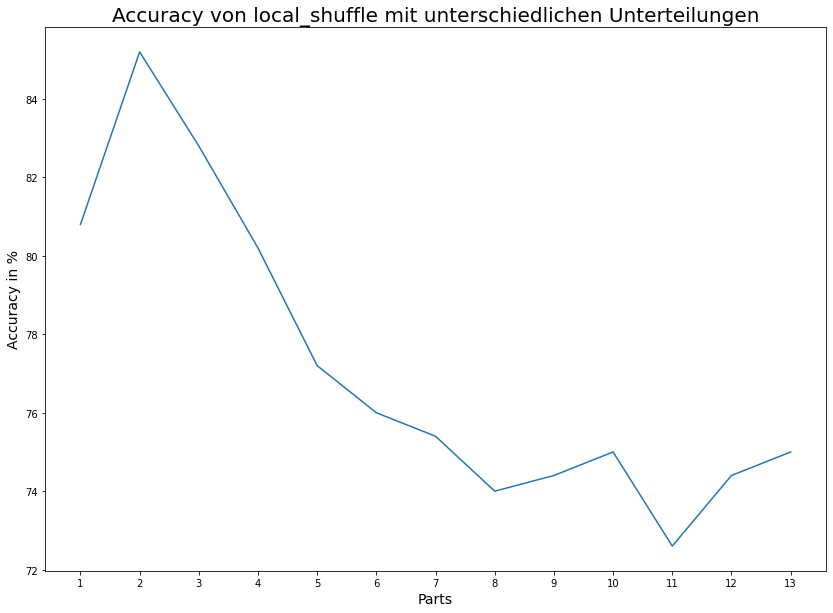

In [15]:
from matplotlib.figure import Figure
from matplotlib.ticker import MaxNLocator

x = np.array([i for i in range(len(buckets_result))])
#print(x+1)
ax = plt.figure(figsize=(14,10)).gca()
ax.xaxis.set_major_locator(MaxNLocator(integer=True))

plt.plot(x+1, np.array(buckets_result)*100)
plt.xticks(x+1)
ax.set_title("Accuracy von local_shuffle mit unterschiedlichen Unterteilungen", fontsize=20)
ax.set_xlabel("Parts", fontsize=14)
ax.set_ylabel("Accuracy in %", fontsize=14)
plt.savefig("example.jpg")
plt.show()

#sns.lineplot(x = x+1, y = buckets_result)

In [12]:
buckets_result

[0.808,
 0.852,
 0.828,
 0.802,
 0.772,
 0.76,
 0.754,
 0.74,
 0.744,
 0.75,
 0.726,
 0.744,
 0.75]

In [17]:
np.concatenate(([1,2,3,4],[1,3,5,7,8]))

array([1, 2, 3, 4, 1, 3, 5, 7, 8])

In [35]:
arr1 = [i for i in range(4000000)]
arr2 = [i for i in range(4000000)]

In [36]:
np.concatenate([arr1, arr2])

array([      0,       1,       2, ..., 3999997, 3999998, 3999999])

In [37]:
arr1.append(arr2)